In [17]:
import h5py
import numpy as np
import operator
import visualisation
import pandas as pd
import matplotlib.pyplot as plt

import re
from math import asin, cos, radians, sin, sqrt
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.dates import DateFormatter
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
from sklearn import preprocessing


import matplotlib as mpl
import matplotlib.pyplot as plt

from dtw import dtw
from IPython.display import Audio, display
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.colors import rgb2hex
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sporco import plot, util
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl

plt.rcParams["figure.figsize"] = (16,8)


In [18]:
PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train.h5"
PATH_TO_TRAINING_TARGET = "data/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))

/Users/Claudia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


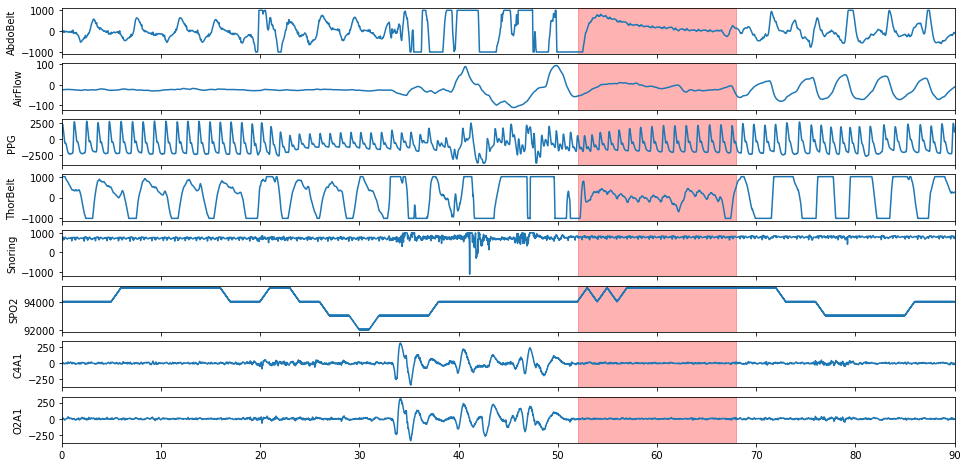

In [131]:
visualisation.visualise_index(0, h5_file, mask)

## Preprocessing


Each row of x contains the data from a single window. The training set contains 4400 windows and the testing set 4400 windows. x has 72002 columns which contains:
- 0: sample index
- 1: subject index
- 2 to 9001: Abdominal belt
- 9002 to 18001: Airflow
- 18002 to 27001: PPG (Photoplethysmogram)
- 27002 to 36001: Thoracic belt
- 36002 to 45001: Snoring indicator
- 45002 to 54001: SPO2
- 54002 to 63001: C4-A1
- 63002 to 72001:O2-A1


1. We denoise the signals using SSA



In [21]:
X_train = np.array(h5_file.get('data'))

In [22]:
X_train_arrays = np.zeros((8,4400,9000))
for i in range(8):
    X_train_arrays[i] = X_train[:, (2+9000*i):(2+9000*(i+1))]

Let's see how SSA behaves on a single signal.

In [ ]:
# Useful functions for SSA

try:
    from numpy.lib.stride_tricks import (
        sliding_window_view,
    )  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]


except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )
    
def average_anti_diag(traj_matrix: np.ndarray) -> np.ndarray:
    """Average anti diagonal elements of a 2d array"""
    x1d = [
        np.mean(traj_matrix[::-1, :].diagonal(i))
        for i in range(-traj_matrix.shape[0] + 1, traj_matrix.shape[1])
    ]
    return np.array(x1d)

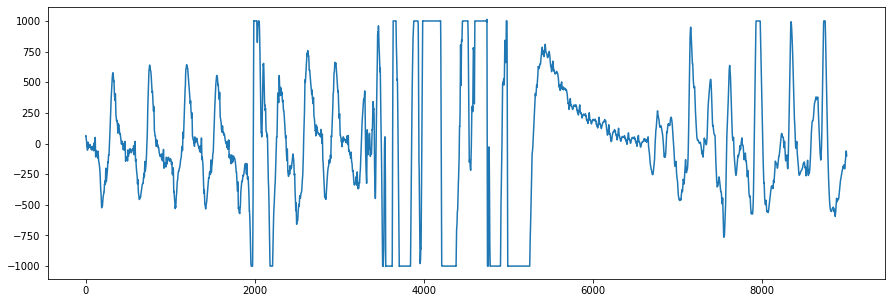

In [171]:
signal = X_train_arrays[0][0]
fig, ax = fig_ax()
ax.plot(signal)

In [172]:
window_shape = 14
trajectory_matrix = get_trajectory_matrix(signal, window_shape)

In [173]:
# SVD
u, eigenvals, vh = np.linalg.svd(trajectory_matrix, full_matrices=False)

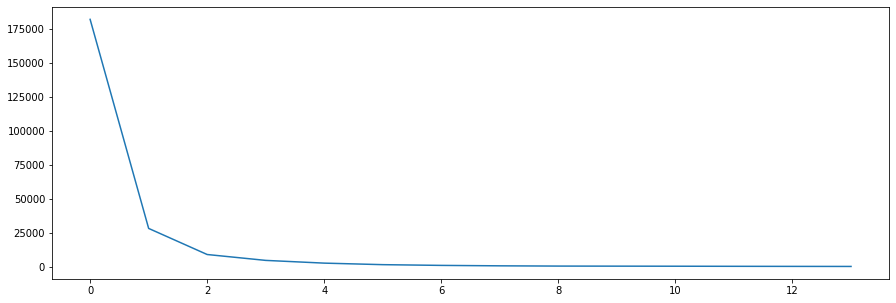

In [174]:
fig, ax = fig_ax()
ax.plot(eigenvals)

In [175]:
ssa_decomposition = np.zeros((signal.size, window_shape))

for (ind, (left, sigma, right)) in enumerate(zip(u.T, eigenvals, vh)):
    ssa_decomposition.T[ind] = average_anti_diag(
        sigma * np.dot(left.reshape(-1, 1), right.reshape(1, -1))
    )

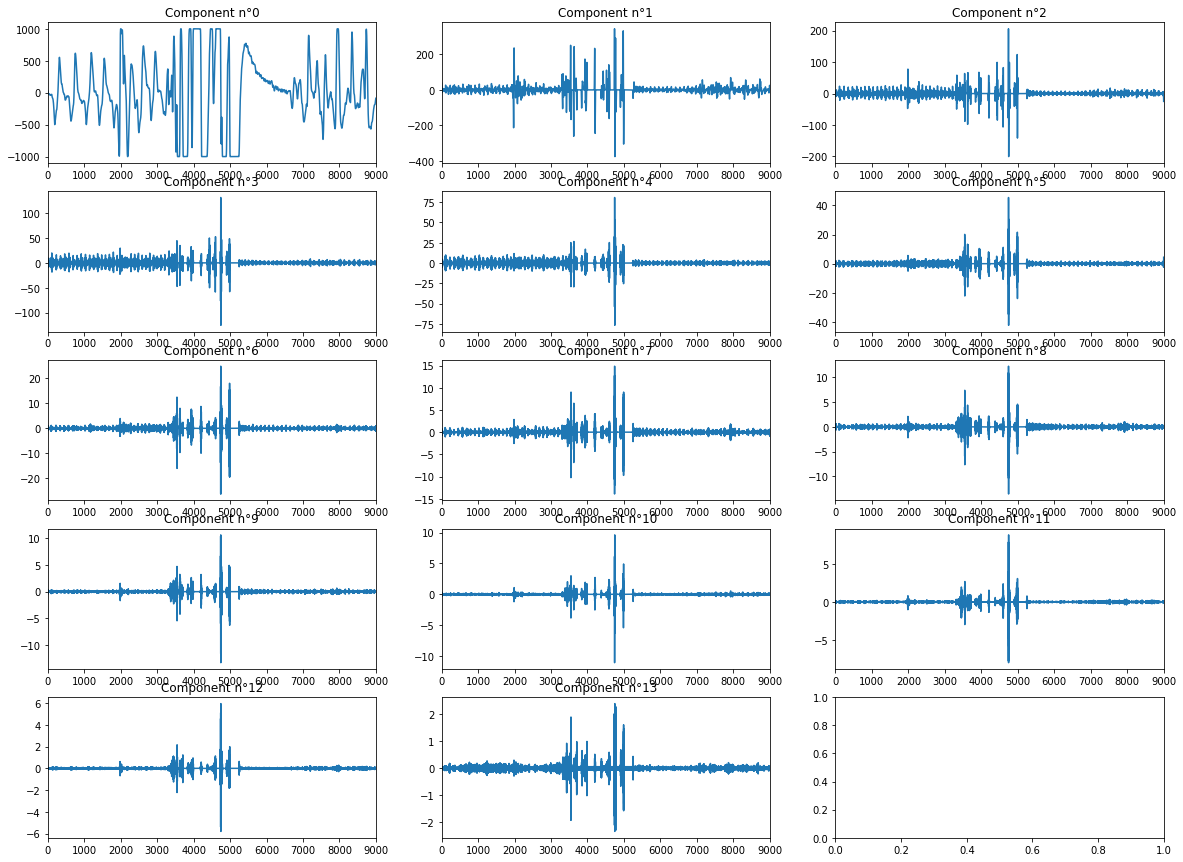

In [176]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

for (ind, (component, ax)) in enumerate(
    zip(ssa_decomposition.T, ax_arr.flatten())
):
    ax.plot(component)
    ax.set_xlim(0, component.size)
    #ax.set_ylim(-2, 2)
    ax.set_title(f"Component n°{ind}")

We see that the signal seems to be made principaly of only the first component, rhe rest of them seem to compose the noise in the signal. Let's reconstruct the signal by adding each component at a time.

MSE  = 19457939.59
MSE  = 3651401.89
MSE  = 1095063.64
MSE  = 341159.41
MSE  = 127393.52
MSE  = 57962.59
MSE  = 28277.38
MSE  = 17584.40
MSE  = 10861.48
MSE  = 5868.39
MSE  = 2729.04
MSE  = 1055.98
MSE  = 271.82
MSE  = 0.00


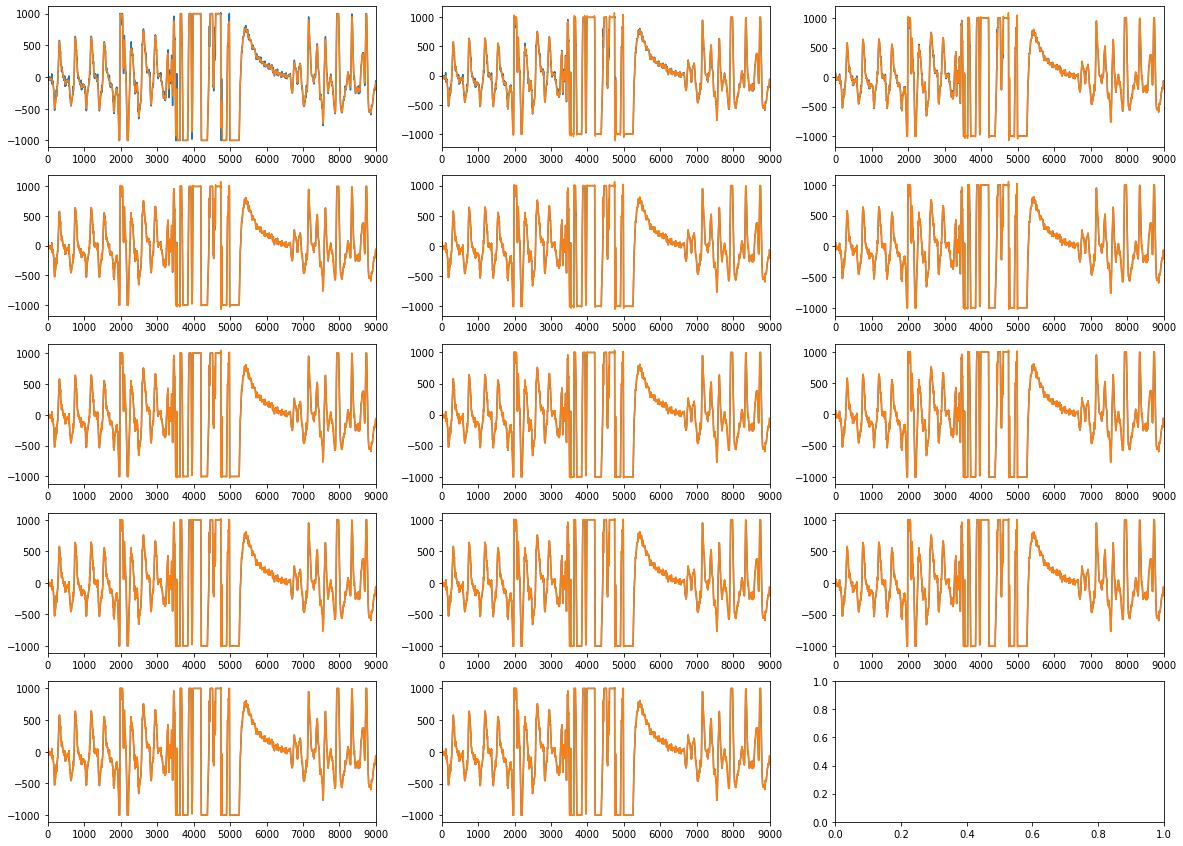

In [180]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

reconstruction = np.zeros(signal.size)

for component, ax in zip(ssa_decomposition.T, ax_arr.flatten()):
    reconstruction += component
    ax.plot(signal)
    ax.plot(reconstruction)
    ax.set_xlim(0, reconstruction.size)
    print(f"MSE  = {np.mean(np.linalg.norm(reconstruction - signal)**2):.2f}")
    #ax.set_ylim(-5, 4)

The reconstruction seems to be mostly achieved by the first component, but to be more precise, it is a good idea to also add the second one.
Let's see if for each com

In [220]:
window_shape = 14

def plt_eigenvals_signal(signal_index, X_train=X_train_arrays,window_shape=window_shape):
    
    eigenvals_m = np.zeros((4400, 14))
    
    for j in range(4400):
        signal = X_train[signal_index][j]
        trajectory_matrix = get_trajectory_matrix(signal, window_shape)
        _, eigenvals, _ = np.linalg.svd(trajectory_matrix, full_matrices=False)
        eigenvals_m[j] = eigenvals
        
    fig, ax = fig_ax() 
    
    for i in range(14):
        ax.scatter([i]*4400, eigenvals_m[:,i], c='k', alpha=0.01)
    
    ax.scatter([i for i in range(14)],np.mean(eigenvals_m, axis=0), c='red', label = 'Mean value')
    ax.stem([i for i in range(14)], np.mean(eigenvals_m, axis=0), markerfmt=' ')
    ax.legend()

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

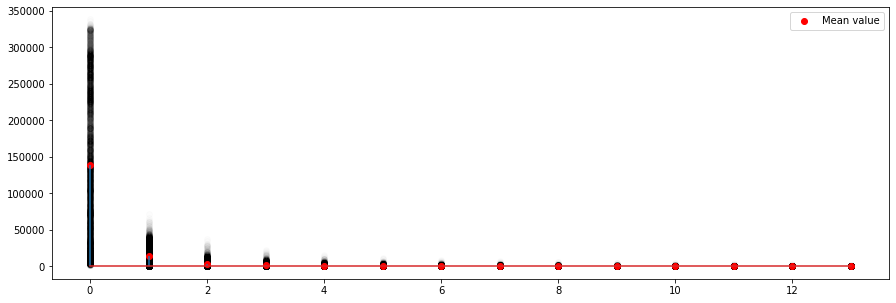

In [221]:
plt_eigenvals_signal(0)

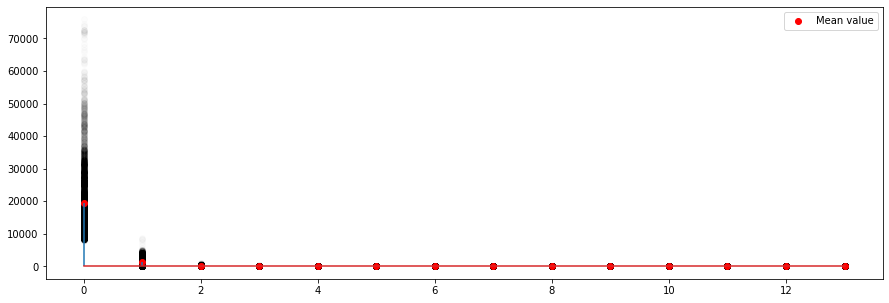

In [222]:
plt_eigenvals_signal(1)

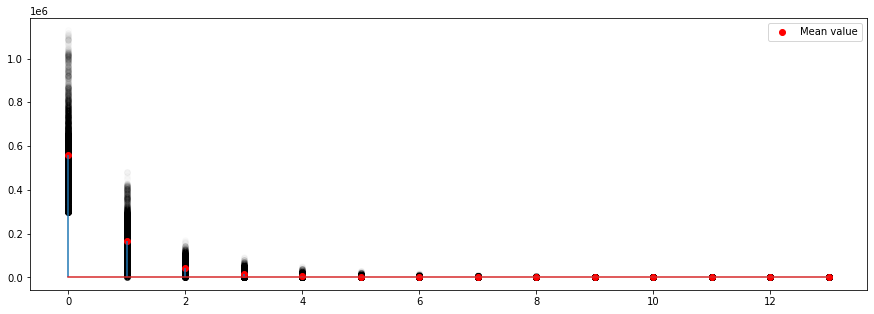

In [223]:
plt_eigenvals_signal(2)

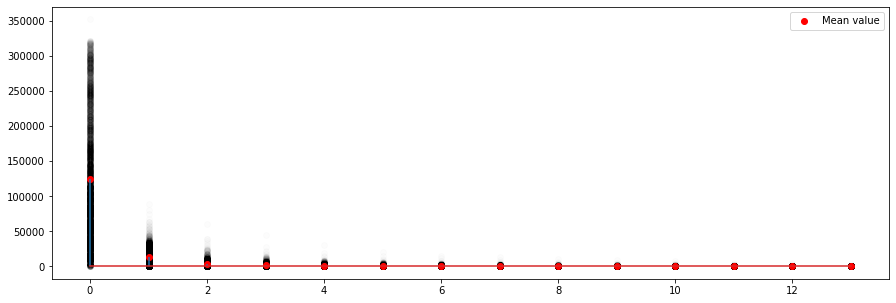

In [224]:
plt_eigenvals_signal(3)

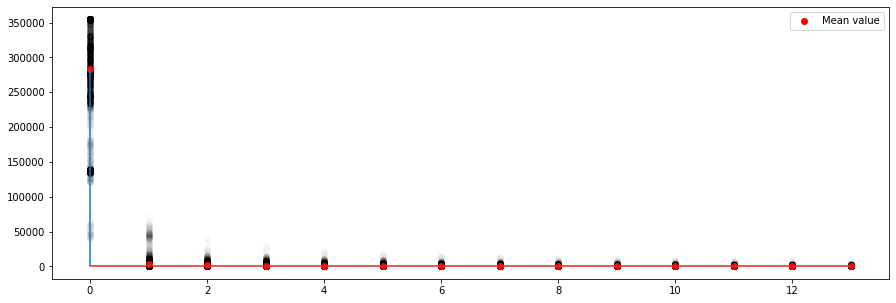

In [225]:
plt_eigenvals_signal(4)

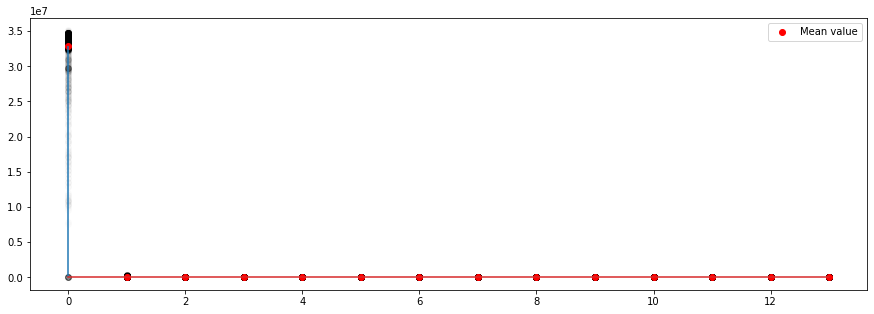

In [226]:
plt_eigenvals_signal(5)

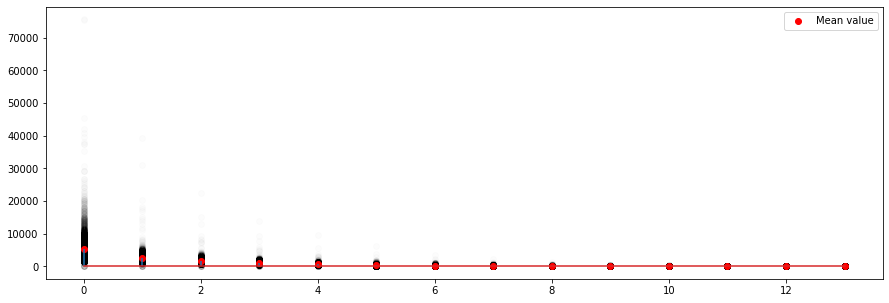

In [227]:
plt_eigenvals_signal(6)

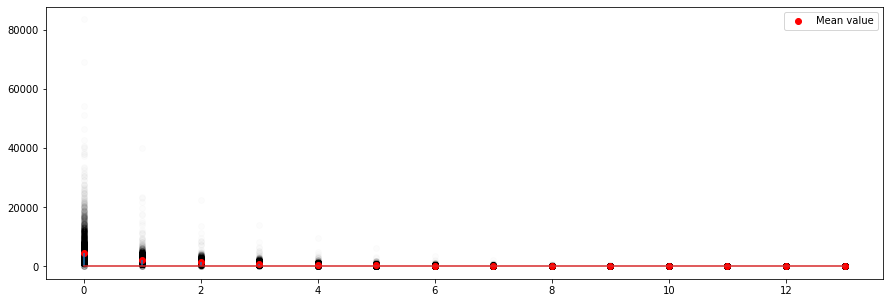

In [228]:
plt_eigenvals_signal(7)

We recover the denoised signals by reconstructing the original signal with only the first two components of each.
We save them on X_train_denoised

In [272]:
window_shape=14
def reconstruct_signal(signal, n_components=2, window_shape=window_shape):
    
    trajectory_matrix = get_trajectory_matrix(signal, window_shape)
    u, eigenvals, vh = np.linalg.svd(trajectory_matrix, full_matrices=False)
    ssa_decomposition = np.zeros((signal.size, window_shape))
    
    for (ind, (left, sigma, right)) in enumerate(zip((u.T)[:n_components], eigenvals[:n_components], vh[:n_components])):
        ssa_decomposition.T[ind] = average_anti_diag(
            sigma * np.dot(left.reshape(-1, 1),right.reshape(1, -1)))
    
    reconstruction = np.zeros(signal.size)
    
    for component in (ssa_decomposition.T)[:n_components]:
        reconstruction += component
    
    return(reconstruction)

def denoise_array(array, signal_idx, n_components=2, window_shape=window_shape):
    denoised_array = np.zeros(array.shape[1:])
    for j in range(4400):
      denoised_signal = reconstruct_signal(array[signal_idx,j], n_components, window_shape)
      denoised_array[j] = denoised_signal
      if j % 100 == 0:
        print(f"Denoised signal {j}")
    #np.savetxt(path_to_data + "denoised_signals_" + str(signal_idx) + ".csv" , denoised_array, delimiter=",")
    return(denoised_array)

In [275]:
X_train_denoised = denoise_array(X_train_arrays,3)

Denoised signal 0
Denoised signal 100
Denoised signal 200
Denoised signal 300
Denoised signal 400
Denoised signal 500
Denoised signal 600
Denoised signal 700
Denoised signal 800
Denoised signal 900
Denoised signal 1000
Denoised signal 1100
Denoised signal 1200
Denoised signal 1300
Denoised signal 1400
Denoised signal 1500
Denoised signal 1600
Denoised signal 1700
Denoised signal 1800
Denoised signal 1900
Denoised signal 2000
Denoised signal 2100
Denoised signal 2200
Denoised signal 2300
Denoised signal 2400
Denoised signal 2500
Denoised signal 2600
Denoised signal 2700
Denoised signal 2800
Denoised signal 2900
Denoised signal 3000
Denoised signal 3100
Denoised signal 3200
Denoised signal 3300
Denoised signal 3400
Denoised signal 3500
Denoised signal 3600
Denoised signal 3700
Denoised signal 3800
Denoised signal 3900
Denoised signal 4000
Denoised signal 4100
Denoised signal 4200
Denoised signal 4300


In [276]:
h5f = h5py.File('data__3.h5', 'w')
h5f.create_dataset('dataset_1', data=X_train_denoised)
h5f.close()

Open all of the denoised signals

In [281]:
X_train_denoised = np.zeros(X_train_arrays.shape)
for i in range(8):
    h5_file = h5py.File("data__" + str(i)+".h5", 'r')
    X_train_denoised[i] = np.array(h5_file.get('dataset_1'))

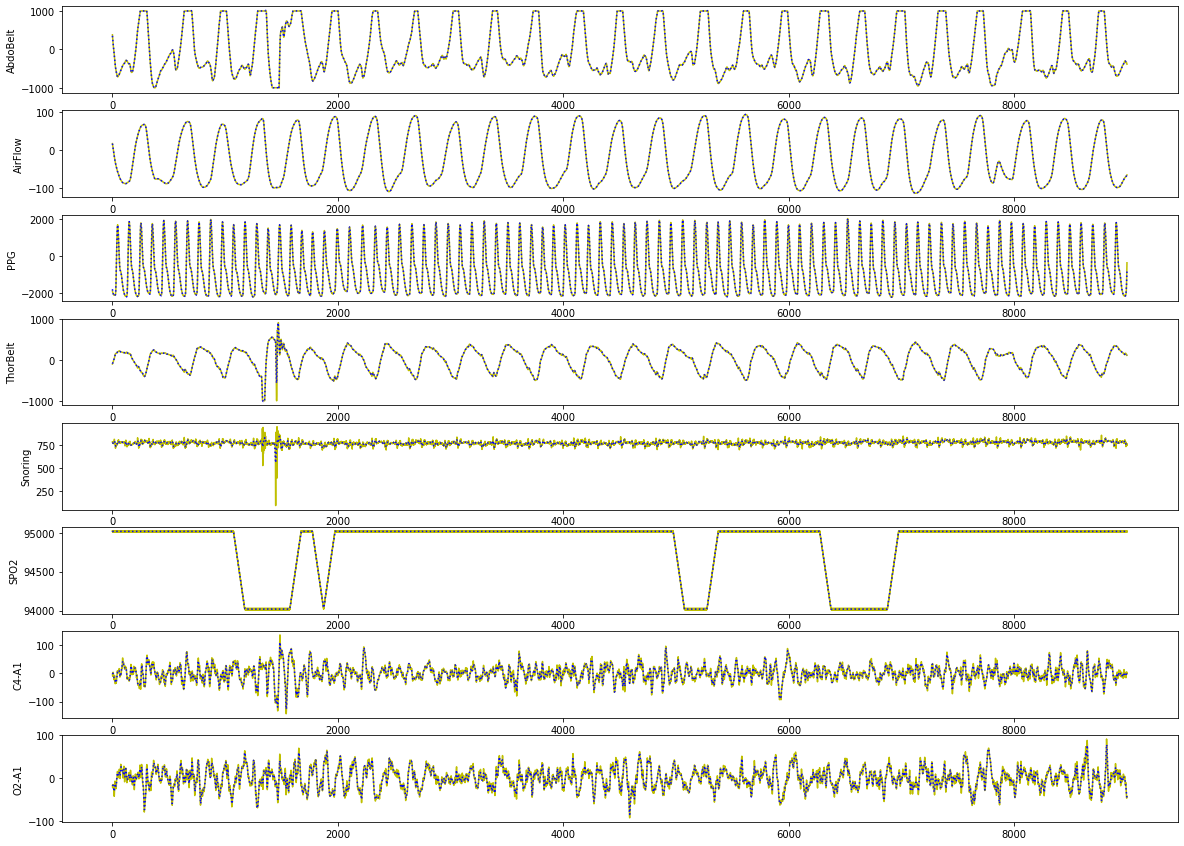

In [308]:
idx_signal = 20

fig, ax_arr = plt.subplots(
    nrows=8,
    figsize=(20,15),)

signal_names = ["AbdoBelt", "AirFlow", "PPG", "ThorBelt", "Snoring", "SPO2", "C4-A1", "O2-A1"] 

for i in range(8):
    
    ax_arr[i].plot(X_train_arrays[i,idx_signal], c='y')
    ax_arr[i].plot(X_train_denoised[i,idx_signal], c='b', linestyle='dotted')
    ax_arr[i].set_ylabel(signal_names[i])
    

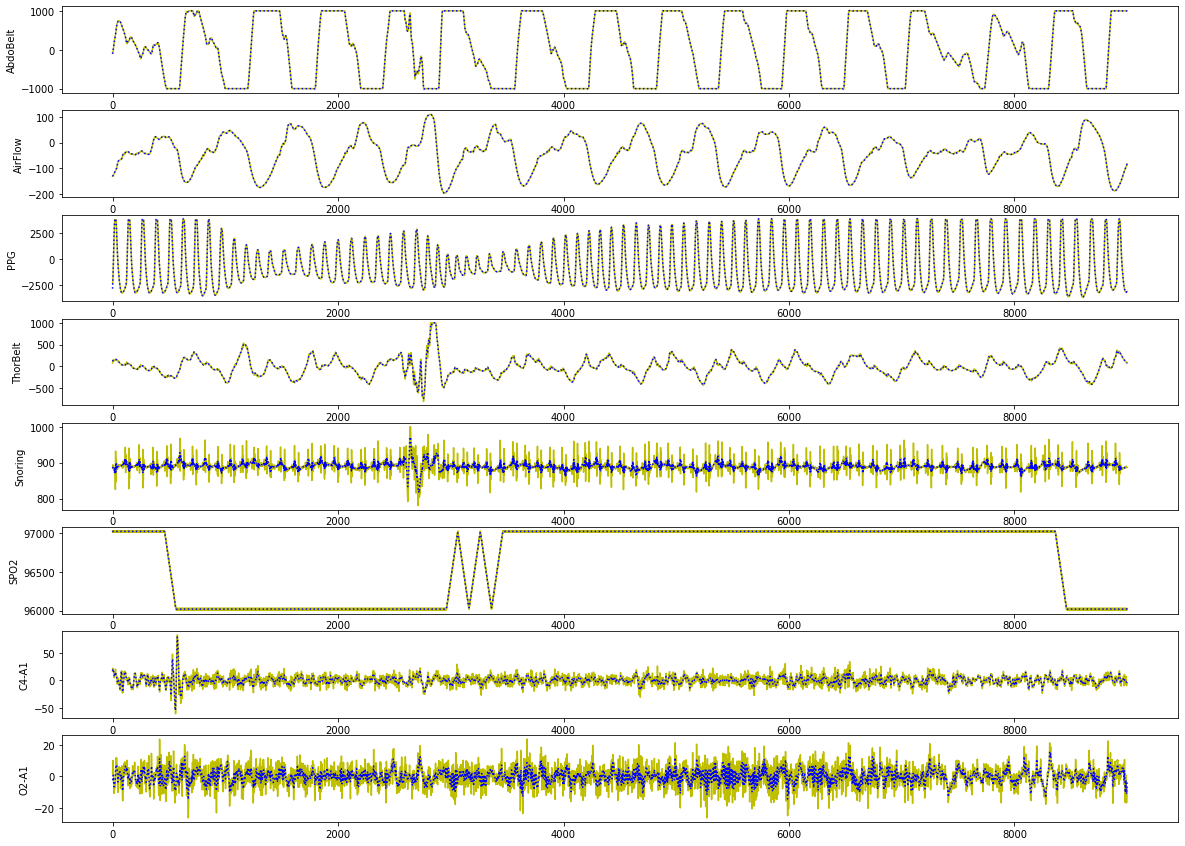

In [314]:
idx_signal = np.random.randint(4400)

fig, ax_arr = plt.subplots(
    nrows=8,
    figsize=(20,15),)

signal_names = ["AbdoBelt", "AirFlow", "PPG", "ThorBelt", "Snoring", "SPO2", "C4-A1", "O2-A1"] 

for i in range(8):
    
    ax_arr[i].plot(X_train_arrays[i,idx_signal], c='y')
    ax_arr[i].plot(X_train_denoised[i,idx_signal], c='b', linestyle='dotted')
    ax_arr[i].set_ylabel(signal_names[i])
    

In [313]:
X_train_denoised[5,idx_signal]

array([96026.14330129, 96011.70044868, 96026.14330132, ...,
       96011.70044866, 96026.14330134, 96011.70044866])

We save the denoised signals as an array of size $8\times4400\times9000$ and as an array of shape $4400\times(9000+2)$

In [286]:
h5f = h5py.File('X_train_denoised_array.h5', 'w')
h5f.create_dataset('data', data=X_train_denoised)
h5f.close()

In [292]:
X_train_denoised_ct = np.zeros(X_train.shape)

X_train_denoised_ct[:,:2] = X_train[:,:2]

for sample in range(4400):
    for i in range(8):
        X_train_denoised_ct[sample,(2+9000*i):(2+9000*(i+1))] = X_train_denoised[i,sample]

In [294]:
h5f = h5py.File('X_train_denoised_ct.h5', 'w')
h5f.create_dataset('data', data=X_train_denoised_ct)
h5f.close()